# Load all required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install opencv-python
import cv2
import pandas as pd

In [2]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
import tensorflow as tf

# Load our grayscale(L) and AB images from files

In [3]:
images_gray = np.load('./l/gray_scale.npy')
images_lab = np.load('./ab/ab/ab1.npy')

# Check counts of images in each dataset, for confirmation

In [4]:
len(images_gray)

25000

In [5]:
len(images_lab)

10000

# Verify, based on shape, that grayscale images(L) and AB images have expected layers in them

In [6]:
images_gray[0].shape

(224, 224)

In [7]:
images_lab[0].shape

(224, 224, 2)

# Make a function to grab the grayscale(L), A and B components of our overall LAB image

- This function also converts the aggregated (complete) LAB image into a RGB format prior to returning

In [8]:
def create_color_image_from_lab_grayscale(img_gray, img_lab):
    # import required packages
    import cv2
    import numpy as np
    
    # create a basic numpy array to contain our disaggregated image
    img = np.zeros((224, 224, 3))
    
    # add our grayscale part to layer one ('L')
    img[:, :, 0] = img_gray
    
    # add the two ('A' and 'B') layers from lab on top of the grayscale level one to get the "complete function"
    img[:, :, 1:] = img_lab
    img = img.astype('uint8')
    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img_

# Test out the grayscale image

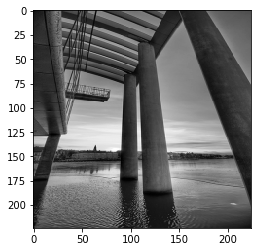

In [9]:
plt.imshow(images_gray[5], cmap="gray")

# Colorized (aggregated) image

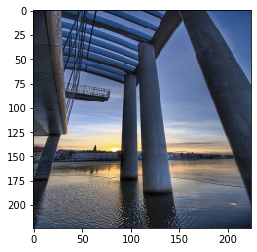

In [10]:
img_complete = create_color_image_from_lab_grayscale(images_gray[5],images_lab[5])
plt.imshow(img_complete)

# Define another function to generate a batch of images instead of just one image for our use

In [11]:
def get_rbg_from_lab(gray_imgs, ab_imgs, n = 10):
    
    imgs = np.zeros((n, 224, 224, 3))
    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]
    
    imgs = imgs.astype("uint8")
    
    imgs_ = []
    for i in range(0, n):
        imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

    imgs_ = np.array(imgs_)

    print(imgs_.shape)
    
    return imgs_

In [12]:
temp = get_rbg_from_lab(images_gray, images_lab, n=6)

(6, 224, 224, 3)


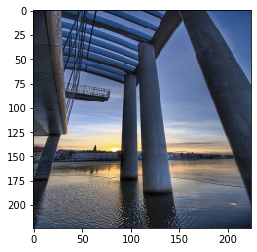

In [13]:
plt.imshow(temp[5])

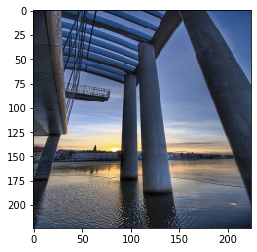

In [14]:
plt.imshow(create_color_image_from_lab_grayscale(images_gray[5],images_lab[5]))

# Try out a model for experimentation

## Import our weights for the Resnet v2 model from disk & load the model

In [15]:
modelv2 = InceptionResNetV2(input_shape = (224, 224, 3), 
                            weights = "./inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")

In [16]:
# create an instance of model based on weights
new_model = Model(inputs = modelv2.inputs, outputs = modelv2.output)

In [17]:
# freeze the weights of all layers, so that they don't change down the line
for i, layer in enumerate(new_model.layers):
    layer.trainable = False

## Check the trainable status of the individual layers

In [18]:
for layer in modelv2.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x118580310> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1185a8fd0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1d1f91cd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x1d201a910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1d202a250> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x118592610> False
<tensorflow.python.keras.layers.core.Activation object at 0x1d20cad90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1d20d55d0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1d20d5e10> False
<tensorflow.python.keras.layers.core.Activation object at 0x1d2104e10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1d210ac10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1d210a510>

## Throw in additional layers for training

In [19]:
x = Reshape((5, 5, 40))(new_model.output)

x = Conv2DTranspose(strides = 2, kernel_size = 5, filters = 40, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , 
                    padding = "valid", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 3, kernel_size = 7, filters = 40, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , 
                    padding = "same", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 3, kernel_size = 9, filters = 20, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , 
                    padding = "same", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 4, kernel_size = 11, filters = 20, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , 
                    padding = "same", activation = tf.nn.relu)(x)
x = Conv2D(strides = 2, kernel_size = 5, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), 
           padding = "valid", activation = tf.nn.relu)(x)
x = Conv2D(strides = 1, kernel_size = 9, filters = 3, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), 
           padding = "valid", activation = tf.nn.relu)(x)


final_model = Model(inputs = new_model.inputs, outputs = x)

## Configure the model for training

- Choosing the right loss function here is key
- We have chosen a appropriate optimizer as well

In [20]:
final_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
                    loss = tf.compat.v1.losses.mean_pairwise_squared_error)

In [21]:
# define additional func for pipelining image aggregation from grayscale (L) + AB = LAB -> RGB
def pipe_line_img(gray_scale_imgs, batch_size = 100, preprocess_f = preprocess_input):
    imgs = np.zeros((batch_size, 224, 224, 3))
    for i in range(0, 3):
        imgs[:batch_size, :, :,i] = gray_scale_imgs[:batch_size]
    return preprocess_f(imgs)

In [22]:
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./folder_to_save_graph_3', 
                                            histogram_freq=0, 
                                            write_graph=True, 
                                            write_images=True)

In [23]:
imgs_for_input = pipe_line_img(images_gray, batch_size = 300)

In [24]:
imgs_for_output = preprocess_input(get_rbg_from_lab(gray_imgs = images_gray, ab_imgs = images_lab, n = 300))

(300, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


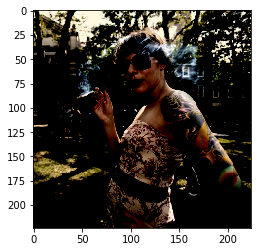

In [25]:
plt.imshow(imgs_for_output[0])

# Fit the model by training on a batch of 300 images (out of 25000)

In [26]:
final_model.fit(imgs_for_input, imgs_for_output, epochs = 5, batch_size = 300, callbacks = [tbCallBack])

Train on 300 samples
Epoch 1/5
300/300 [==============================] - 143s 478ms/sample - loss: 144.2110
Epoch 2/5
300/300 [==============================] - 120s 399ms/sample - loss: 143.9828
Epoch 3/5
300/300 [==============================] - 118s 394ms/sample - loss: 143.9828
Epoch 4/5
300/300 [==============================] - 119s 397ms/sample - loss: 143.9828
Epoch 5/5
300/300 [==============================] - 118s 394ms/sample - loss: 143.9828


In [27]:
prediction2 = final_model.predict(x = pipe_line_img(gray_scale_imgs = images_gray, batch_size = 300))

In [28]:
prediction2.shape

(300, 224, 224, 3)

##  Test the predictions of our trial (Inception) model

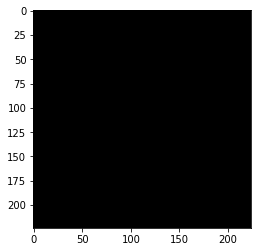

In [29]:
plt.imshow(prediction2[299])

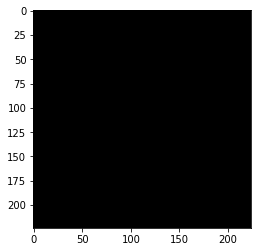

In [30]:
plt.imshow(prediction2[5])

# Try out a very simple model instead

In [31]:
model_simple = Sequential()
model_simple.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model_simple.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model_simple.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model_simple.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 3, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))

In [33]:
model_simple.compile(optimizer = tf.keras.optimizers.Adam(epsilon = 1e-8), loss = tf.compat.v1.losses.mean_pairwise_squared_error)

In [34]:
imgs_for_s = np.zeros((300, 224, 224, 1))
imgs_for_s[:, :, :, 0] = images_gray[:300] 

In [35]:
prediction = model_simple.predict(imgs_for_input)

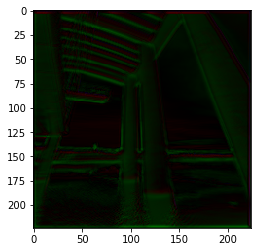

In [41]:
plt.imshow(prediction[5])

# As seen above, this is a pretty primitive capture of our source data, let's train our model for 15 epochs

In [43]:
model_simple.fit(imgs_for_input, imgs_for_output, epochs = 15)

Train on 300 samples
Epoch 1/15
300/300 [==============================] - 13s 42ms/sample - loss: 14.0304
Epoch 2/15
300/300 [==============================] - 12s 39ms/sample - loss: 10.7045
Epoch 3/15
300/300 [==============================] - 14s 46ms/sample - loss: 9.2460
Epoch 4/15
300/300 [==============================] - 12s 41ms/sample - loss: 6.6108
Epoch 5/15
300/300 [==============================] - 12s 40ms/sample - loss: 5.0314
Epoch 6/15
300/300 [==============================] - 12s 40ms/sample - loss: 4.3518
Epoch 7/15
300/300 [==============================] - 12s 41ms/sample - loss: 3.9527
Epoch 8/15
300/300 [==============================] - 12s 39ms/sample - loss: 3.7503
Epoch 9/15
300/300 [==============================] - 11s 37ms/sample - loss: 3.6732
Epoch 10/15
300/300 [==============================] - 12s 39ms/sample - loss: 3.6284
Epoch 11/15
300/300 [==============================] - 12s 39ms/sample - loss: 3.5471
Epoch 12/15
300/300 [===================

In [44]:
prediction = model_simple.predict(imgs_for_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


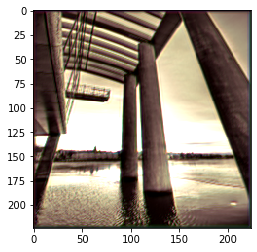

In [45]:
plt.imshow(prediction[5])

# This does a lot better! Let's train further, for a much larger number of epochs

In [47]:
# should take almost 4.6 hours to train, best case scenario
model_simple.fit(imgs_for_input, imgs_for_output, epochs = 1100, batch_size=16)

Train on 300 samples
Epoch 1/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.7267
Epoch 2/1100
300/300 [==============================] - 13s 45ms/sample - loss: 1.7156
Epoch 3/1100
300/300 [==============================] - 13s 43ms/sample - loss: 1.6918
Epoch 4/1100
300/300 [==============================] - 13s 44ms/sample - loss: 1.6821
Epoch 5/1100
300/300 [==============================] - 15s 48ms/sample - loss: 1.6673
Epoch 6/1100
300/300 [==============================] - 14s 48ms/sample - loss: 1.6455
Epoch 7/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.6213
Epoch 8/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.5955
Epoch 9/1100
300/300 [==============================] - 12s 38ms/sample - loss: 1.5933
Epoch 10/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.5576
Epoch 11/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.5502
Epoch 12/1100
300/30

Epoch 94/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3151
Epoch 95/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3136
Epoch 96/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3318
Epoch 97/1100
300/300 [==============================] - 12s 38ms/sample - loss: 1.3221
Epoch 98/1100
300/300 [==============================] - 12s 38ms/sample - loss: 1.3213
Epoch 99/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3143
Epoch 100/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3098
Epoch 101/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3146
Epoch 102/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.3316
Epoch 103/1100
300/300 [==============================] - 12s 42ms/sample - loss: 1.3128
Epoch 104/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3033
Epoch 105/1100
300/300 [===

300/300 [==============================] - 12s 39ms/sample - loss: 1.3050
Epoch 187/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.3029
Epoch 188/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.2994
Epoch 189/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3055
Epoch 190/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.2973
Epoch 191/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3033
Epoch 192/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.2924
Epoch 193/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3107
Epoch 194/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3091
Epoch 195/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3109
Epoch 196/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.3224
Epoch 197/1100
300/300 [============

300/300 [==============================] - 13s 42ms/sample - loss: 1.3073
Epoch 279/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.2972
Epoch 280/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.2814
Epoch 281/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.3005
Epoch 282/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.2940
Epoch 283/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.2922
Epoch 284/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.3044
Epoch 285/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.2828
Epoch 286/1100
300/300 [==============================] - 13s 43ms/sample - loss: 1.2974
Epoch 287/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.2898
Epoch 288/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.2933
Epoch 289/1100
300/300 [============

300/300 [==============================] - 13s 42ms/sample - loss: 1.2839
Epoch 371/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.2910
Epoch 372/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.2791
Epoch 373/1100
300/300 [==============================] - 13s 42ms/sample - loss: 1.2959
Epoch 374/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.3117
Epoch 375/1100
300/300 [==============================] - 12s 40ms/sample - loss: 1.2955
Epoch 376/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.2947
Epoch 377/1100
300/300 [==============================] - 12s 42ms/sample - loss: 1.2957
Epoch 378/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.2977
Epoch 379/1100
300/300 [==============================] - 12s 41ms/sample - loss: 1.2877
Epoch 380/1100
300/300 [==============================] - 13s 42ms/sample - loss: 1.2859
Epoch 381/1100
300/300 [============

300/300 [==============================] - 12s 38ms/sample - loss: 1.2916
Epoch 463/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.2804
Epoch 464/1100
300/300 [==============================] - 12s 38ms/sample - loss: 1.2829
Epoch 465/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2888
Epoch 466/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2874
Epoch 467/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.3004
Epoch 468/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2849
Epoch 469/1100
300/300 [==============================] - 12s 39ms/sample - loss: 1.2923
Epoch 470/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2932
Epoch 471/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2926
Epoch 472/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2951
Epoch 473/1100
300/300 [============

300/300 [==============================] - 11s 37ms/sample - loss: 1.2689
Epoch 555/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2799
Epoch 556/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2809
Epoch 557/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2801
Epoch 558/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2917
Epoch 559/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2807
Epoch 560/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2760
Epoch 561/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2804
Epoch 562/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2805
Epoch 563/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2839
Epoch 564/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2772
Epoch 565/1100
300/300 [============

300/300 [==============================] - 11s 37ms/sample - loss: 1.2745
Epoch 647/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2763
Epoch 648/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2861
Epoch 649/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2826
Epoch 650/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2727
Epoch 651/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2748
Epoch 652/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2618
Epoch 653/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2737
Epoch 654/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2753
Epoch 655/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2898
Epoch 656/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2797
Epoch 657/1100
300/300 [============

300/300 [==============================] - 11s 37ms/sample - loss: 1.2757
Epoch 739/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2872
Epoch 740/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2858
Epoch 741/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2836
Epoch 742/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2779
Epoch 743/1100
300/300 [==============================] - 12s 38ms/sample - loss: 1.2781
Epoch 744/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2736
Epoch 745/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2828
Epoch 746/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2805
Epoch 747/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2739
Epoch 748/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2932
Epoch 749/1100
300/300 [============

300/300 [==============================] - 11s 37ms/sample - loss: 1.2733
Epoch 831/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2758
Epoch 832/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2748
Epoch 833/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2753
Epoch 834/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2802
Epoch 835/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2727
Epoch 836/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2894
Epoch 837/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2881
Epoch 838/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2762
Epoch 839/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.3012
Epoch 840/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2779
Epoch 841/1100
300/300 [============

300/300 [==============================] - 11s 37ms/sample - loss: 1.2693
Epoch 923/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2739
Epoch 924/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2888
Epoch 925/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2767
Epoch 926/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2757
Epoch 927/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2724
Epoch 928/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2685
Epoch 929/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2760
Epoch 930/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2812
Epoch 931/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2838
Epoch 932/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2675
Epoch 933/1100
300/300 [============

300/300 [==============================] - 11s 37ms/sample - loss: 1.2700
Epoch 1015/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2653
Epoch 1016/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2777
Epoch 1017/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2733
Epoch 1018/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2674
Epoch 1019/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2780
Epoch 1020/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2763
Epoch 1021/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2744
Epoch 1022/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2749
Epoch 1023/1100
300/300 [==============================] - 11s 38ms/sample - loss: 1.2816
Epoch 1024/1100
300/300 [==============================] - 11s 37ms/sample - loss: 1.2744
Epoch 1025/1100
300/300 [=

In [48]:
prediction = model_simple.predict(imgs_for_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


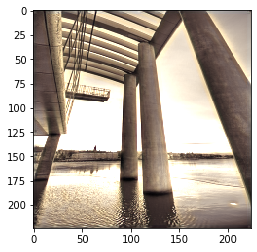

In [49]:
plt.imshow(prediction[5])

In [50]:
import os
print(os.getcwd())

/Users/rzende/Downloads/image-colorization
